## Demo 2: HKR Classifier on toy dataset
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/deel-ai/deel-lip/blob/master/doc/notebooks/demo2.ipynb)

In this demo notebook we will show how to build a robust
classifier based on the regularized version of the Kantorovitch-Rubinstein
duality.
We will perform this on the `two moons` synthetic dataset.

In [ ]:
# pip install deel-lip -qqq

In [1]:
import numpy as np
from sklearn.datasets import make_moons, make_circles  # the synthetic dataset
import matplotlib.pyplot as plt 
import seaborn as sns


# in order to build our classifier we will use element from tensorflow along with
# layers from deel-lip
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import ReLU, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import binary_accuracy

from deel.lip.model import Model  # use of deel.lip is not mandatory but offers the vanilla_export feature
from deel.lip.layers import SpectralConv2D, SpectralDense, FrobeniusDense
from deel.lip.activations import MaxMin, GroupSort, FullSort, GroupSort2
from deel.lip.losses import HKR, KR, HingeMargin  # custom losses for HKR robust classif

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-lzatifz2 because the default path (/home/thibaut.boissin/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
2021-09-08 18:23:52.158609: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


### Parameters 

Let's first construct our two moons dataset

In [2]:
circle_or_moons = 1  # 0 for circle , 1 for moons
n_samples=5000  # number of sample in the dataset
noise=0.05  # amount of noise to add in the data. Tested with 0.14 for circles 0.05 for two moons
factor=0.4  # scale factor between the inner and the outer circle

In [3]:
if circle_or_moons == 0:
    X,Y=make_circles(n_samples=n_samples,noise=noise,factor=factor)
else:
    X,Y=make_moons(n_samples=n_samples,noise=noise)

# When working with the HKR-classifier, using labels {-1, 1} instead of {0, 1} is advised.
# This will be explained further on 
Y[Y==1]=-1
Y[Y==0]=1

/home/thibaut.boissin/envs/tf24/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/thibaut.boissin/envs/tf24/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:>

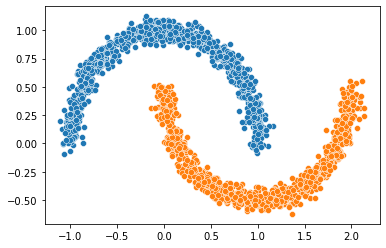

In [4]:
X1=X[Y==1]
X2=X[Y==-1]
sns.scatterplot(X1[:1000,0],X1[:1000,1])
sns.scatterplot(X2[:1000,0],X2[:1000,1])

### Relation with optimal transport

In this setup we can solve the optimal transport problem
between the distribution of `X[Y==1]` and `X[Y==-1]`. This
usually require to match each element of the first distribution
with an element of the second distribution such that this minimize
a global cost. In our setup this cost is the $ l_1 $ distance, which
will allow us to make use of the KR dual formulation. The overall cost 
is then the $W_1$ distance.

#### Wasserstein distance

The wasserstein distance measure the distance between two probability distribution. Wikipedia article gives a more intuitive definition of it:

> Intuitively, if each distribution is viewed as a unit amount of "dirt" piled on {\displaystyle M}M, the metric is the minimum "cost" of turning one pile into the other, which is assumed to be the amount of dirt that needs to be moved times the mean distance it has to be moved. Because of this analogy, the metric is known in computer science as the earth mover's distance.

Mathematically it is defined as:

$$
W_1(\mu,\nu) = \inf_{\pi \in \Pi(\mu,\nu)}\underset{x,z \sim \pi}{\mathbb{E}}\parallel \textbf{x}-\textbf{z} \parallel
$$

where $\Pi(\mu,\nu)$ is the set of all probability measures on $\Omega\times \Omega$ with marginals $\mu$ and $\nu$. In most case this equation is not tractable.


However the $W_1$ distance is known to be untractable in general.

#### KR dual formulation

In our setup, the KR dual formulation is stated as following:
$$ W_1(\mu, \nu) = \sup_{f \in Lip_1(\Omega)} \underset{\textbf{x} \sim \mu}{\mathbb{E}} \left[f(\textbf{x} )\right] -\underset{\textbf{x}  \sim \nu}{\mathbb{E}} \left[f(\textbf{x} )\right] $$

This state the problem as an optimization problem over the 1-lipschitz functions.
Therefore k-Lipschitz networks allows us to solve this maximization problem.

#### Hinge-KR classification

When dealing with $W_1$ one may note that many functions maximize the maximization problem
described above. Also we want this function to be meaningfull in terms of classification.
To do so, we want f to be centered in 0, which can be done without altering the inital problem.
By doing so we can use the obtained function for binary classification, by looking at the sign of $f$.

In order to enforce this, we will add a Hinge term to the loss. It has been shown that this new problem
is still a optimal transport problem and that this problem admit a meaningfull optimal solution.

### HKR-Classifier

Now we will show how to build a binary classifier based on the regularized version of the KR dual problem.

In order to ensure the 1-Lipschitz constraint `deel-lip` uses spectral normalization. These layers also can also use Bjork orthonormalization to ensure that the gradient of the layer is 1 almost everywhere. Experiment shows that the optimal solution lie in this sub-class of functions.

In [5]:
batch_size=256
steps_per_epoch=40480
epoch=10
hidden_layers_size = [256,128,64]  # stucture of the network
activation = FullSort  # other lipschitz activation are ReLU, MaxMin, GroupSort2, GroupSort
min_margin= 0.29  # minimum margin to enforce between the values of f for each class

In [6]:
# build data generator
def otp_generator(batch_size, X, Y):
    Y_ix = np.array([i for i in range(Y.shape[0])])
    Y0_ix = Y_ix[Y == 1]
    Y1_ix = Y_ix[Y == -1]
    half = Y.shape[0] // 2
    while True:
        batch_x = np.zeros(((batch_size,) + (X[0].shape)), dtype=np.float32)
        batch_y = np.zeros((batch_size, 1), dtype=np.float32)
        ind = np.random.choice(Y0_ix, size=batch_size // 2, replace=False)
        batch_x[:batch_size // 2, ] = X[ind]
        batch_y[:batch_size // 2, 0] = Y[ind]
        ind = np.random.choice(Y1_ix, size=batch_size // 2, replace=False)
        batch_x[batch_size // 2:, ] = X[ind]
        batch_y[batch_size // 2:, 0] = Y[ind]

        yield batch_x, batch_y
gen=otp_generator(batch_size,X,Y)

### Build lipschitz Model

Let's build our model now.

In [7]:
K.clear_session()
# please note that calling the previous helper function has the exact
# same effect as the following code:
inputs = Input((2,))
x = SpectralDense(256, activation=activation())(inputs)
x = SpectralDense(128, activation=activation())(x)
x = SpectralDense(64, activation=activation())(x)
y = FrobeniusDense(1, activation=None)(x)
wass = Model(inputs=inputs, outputs=y)
wass.summary()

2021-09-08 18:23:54.376987: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-09-08 18:23:54.377747: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-09-08 18:23:54.415033: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-08 18:23:54.415345: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce RTX 3080 computeCapability: 8.6
coreClock: 1.83GHz coreCount: 68 deviceMemorySize: 9.78GiB deviceMemoryBandwidth: 707.88GiB/s
2021-09-08 18:23:54.415372: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-09-08 18:23:54.417208: I tensorflow/stream_executor/platform/default/ds

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
spectral_dense (SpectralDens (None, 256)               1537      
_________________________________________________________________
spectral_dense_1 (SpectralDe (None, 128)               65793     
_________________________________________________________________
spectral_dense_2 (SpectralDe (None, 64)                16513     
_________________________________________________________________
frobenius_dense (FrobeniusDe (None, 1)                 129       
Total params: 83,972
Trainable params: 41,985
Non-trainable params: 41,987
_________________________________________________________________


As we can see the network has a gradient equal to 1 almost everywhere as all the layers respect this property.

It is good to note that the last layer is a `FrobeniusDense` this is because, when we have a single
output, it become equivalent to normalize the frobenius norm and the spectral norm (as we only have a single singular value)

In [8]:
optimizer = Adam(lr=0.01)

In [9]:
# as the output of our classifier is in the real range [-1, 1], binary accuracy must be redefined
def HKR_binary_accuracy(y_true, y_pred):
    S_true= tf.dtypes.cast(tf.greater_equal(y_true[:,0], 0),dtype=tf.float32)
    S_pred= tf.dtypes.cast(tf.greater_equal(y_pred[:,0], 0),dtype=tf.float32)
    return binary_accuracy(S_true,S_pred)

In [10]:
wass.compile(
    loss=HKR(alpha=10,min_margin=min_margin),  # HKR stands for the hinge regularized KR loss
    metrics=[
        KR,  # shows the KR term of the loss
        HingeMargin(min_margin=min_margin),  # shows the hinge term of the loss
        HKR_binary_accuracy  # shows the classification accuracy
    ],
    optimizer=optimizer
)

### Learn classification on toy dataset

Now we are ready to learn the classification task on the two moons dataset.

In [11]:
wass.fit_generator(
    gen,
    steps_per_epoch=steps_per_epoch // batch_size, 
    epochs=epoch,
    verbose=1
)

/home/thibaut.boissin/envs/tf24/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2021-09-08 18:23:56.416569: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-09-08 18:23:56.434380: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3600000000 Hz


Epoch 1/10
158/158 [==============================] - 4s 13ms/step - loss: 0.6832 - KR: 0.5668 - HingeMargin: 0.1250 - HKR_binary_accuracy: 0.7808
Epoch 2/10
158/158 [==============================] - 2s 13ms/step - loss: -0.7488 - KR: 0.9578 - HingeMargin: 0.0209 - HKR_binary_accuracy: 0.9795
Epoch 3/10
158/158 [==============================] - 2s 12ms/step - loss: -0.7921 - KR: 0.9734 - HingeMargin: 0.0181 - HKR_binary_accuracy: 0.9865
Epoch 4/10
158/158 [==============================] - 2s 12ms/step - loss: -0.8035 - KR: 0.9783 - HingeMargin: 0.0175 - HKR_binary_accuracy: 0.9875
Epoch 5/10
158/158 [==============================] - 2s 12ms/step - loss: -0.8232 - KR: 0.9749 - HingeMargin: 0.0152 - HKR_binary_accuracy: 0.9913
Epoch 6/10
158/158 [==============================] - 2s 12ms/step - loss: -0.8207 - KR: 0.9690 - HingeMargin: 0.0148 - HKR_binary_accuracy: 0.9920
Epoch 7/10
158/158 [==============================] - 2s 12ms/step - loss: -0.8376 - KR: 0.9940 - HingeMargin: 0.

### Plot output countour line

As we can see the classifier get a pretty good accuracy. Let's now take a look at the learnt function. 
As we are in the 2D space, we can draw a countour plot to visualize f.

In [12]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
batch_size=1024

x = np.linspace(X[:,0].min()-0.2, X[:,0].max()+0.2, 120)
y = np.linspace(X[:,1].min()-0.2, X[:,1].max()+0.2,120)
xx, yy = np.meshgrid(x, y, sparse=False)
X_pred=np.stack((xx.ravel(),yy.ravel()),axis=1)

In [13]:
# make predictions of f
pred=wass.predict(X_pred)

Y_pred=pred
Y_pred=Y_pred.reshape(x.shape[0],y.shape[0])

/home/thibaut.boissin/envs/tf24/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/thibaut.boissin/envs/tf24/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<a list of 7 text.Text objects>

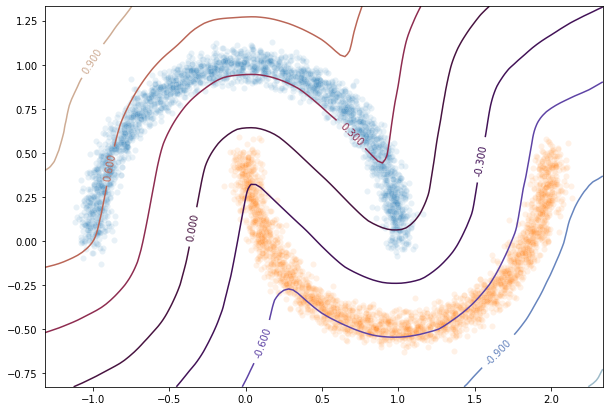

In [14]:
#plot the results
fig = plt.figure(figsize=(10,7))
ax1 = fig.add_subplot(111)

sns.scatterplot(X[Y==1,0],X[Y==1,1],alpha=0.1,ax=ax1)
sns.scatterplot(X[Y==-1,0],X[Y==-1,1],alpha=0.1,ax=ax1)
cset =ax1.contour(xx,yy,Y_pred,cmap='twilight')
ax1.clabel(cset, inline=1, fontsize=10)

### Transfer network to a classical MLP and compare outputs

As we saw, our networks use custom layers in order to constrain training.
However during inference layers behave exactly as regular `Dense` or `Conv2d` layers.
Deel-lip has a functionnality to export a model to it's vanilla keras equivalent. Making it more 
convenient for inference.

In [15]:
from deel.lip.model import vanillaModel
## this is equivalent to test2 = wass.vanilla_export()
test2 = vanillaModel(wass)
test2.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
spectral_dense (Dense)       (None, 256)               768       
_________________________________________________________________
spectral_dense_1 (Dense)     (None, 128)               32896     
_________________________________________________________________
spectral_dense_2 (Dense)     (None, 64)                8256      
_________________________________________________________________
frobenius_dense (Dense)      (None, 1)                 65        
Total params: 41,985
Trainable params: 41,985
Non-trainable params: 0
_________________________________________________________________


In [16]:
pred_test=test2.predict(X_pred)
Y_pred=pred_test
Y_pred=Y_pred.reshape(x.shape[0],y.shape[0])

/home/thibaut.boissin/envs/tf24/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/thibaut.boissin/envs/tf24/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<a list of 7 text.Text objects>

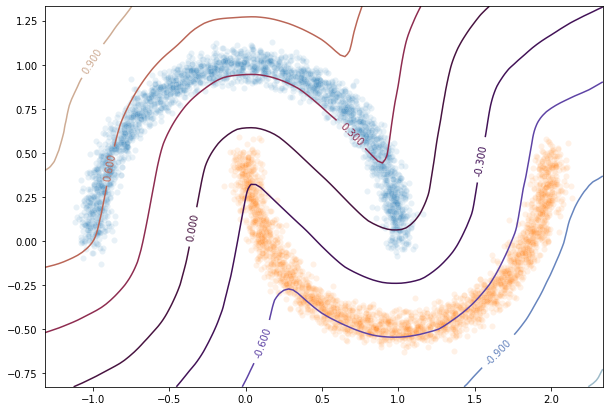

In [17]:
fig = plt.figure(figsize=(10,7))
ax1 = fig.add_subplot(111)
#ax2 = fig.add_subplot(312)
#ax3 = fig.add_subplot(313)
sns.scatterplot(X[Y==1,0],X[Y==1,1],alpha=0.1,ax=ax1)
sns.scatterplot(X[Y==-1,0],X[Y==-1,1],alpha=0.1,ax=ax1)
cset =ax1.contour(xx,yy,Y_pred,cmap='twilight')
ax1.clabel(cset, inline=1, fontsize=10)
